In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Use only a subset to save memory
x_train = x_train[:10000]
y_train = y_train[:10000]
x_test = x_test[:2000]
y_test = y_test[:2000]

# Expand channel to (28,28,1)
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# Resize to 224x224
IMG_SIZE = (96, 96)
x_train = tf.image.resize(x_train, IMG_SIZE).numpy()
x_test= tf.image.resize(x_test, IMG_SIZE).numpy()

# Convert grayscale to RGB (3 channels)
x_train= np.repeat(x_train, 3, axis=-1)
x_test_rgb = np.repeat(x_test, 3, axis=-1)

# Preprocess input for VGG16
x_train = preprocess_input(x_train)
x_test= preprocess_input(x_test)

# One-hot encode labels
y_train = to_categorical(y_train, 10)
y_test= to_categorical(y_test, 10)

print(x_train.shape)
print(y_train.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(10000, 96, 96, 3)
(10000, 10)


In [ ]:
# Load pretrained VGG16 without top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96,96,3))

# GlobalAveragePooling to get feature vector
feature_model = base_model.output
feature_model = GlobalAveragePooling2D()(feature_model)
feature_model = Model(inputs=base_model.input, outputs=feature_model)
# Extract features for test data
features_before = feature_model.predict(x_test)  # Use subset for faster visualization
labels = y_test[:1000]
print("Shape of features_before:", features_before.shape)


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 18s 148ms/step
Shape of features_before: (2000, 1280)


In [ ]:
# Freeze base layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

model=base_model.output
model=GlobalAveragePooling2D()(model)
model=Dense(1024,activation='relu')(model)
model=Dense(512,activation='relu')(model)
output=Dense(10,activation='softmax')(model)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=10, batch_size=64, validation_split=0.2)

# Feature extraction AFTER fine-tuning
feature_model_after = Model(inputs=model.input, outputs=model.layers[-3].output)
features_after = feature_model_after.predict(x_test[:1000])
print("Shape of features_after:", features_after.shape)


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 40s 133ms/step - accuracy: 0.7722 - loss: 0.6807 - val_accuracy: 0.9305 - val_loss: 0.2064
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.9336 - loss: 0.2017 - val_accuracy: 0.9305 - val_loss: 0.1991
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9420 - loss: 0.1743 - val_accuracy: 0.9490 - val_loss: 0.1676
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9523 - loss: 0.1446 - val_accuracy: 0.9540 - val_loss: 0.1393
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.9609 - loss: 0.1138 - val_accuracy: 0.9530 - val_loss: 0.1423
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9650 - loss: 0.1145 - val_accuracy: 0.9550 - val_loss: 0.1296
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9585 - loss: 0.1094 - val_accuracy: 0.9605 - val_loss: 0.1322
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.9735 - loss: 0.0835 - val_a

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


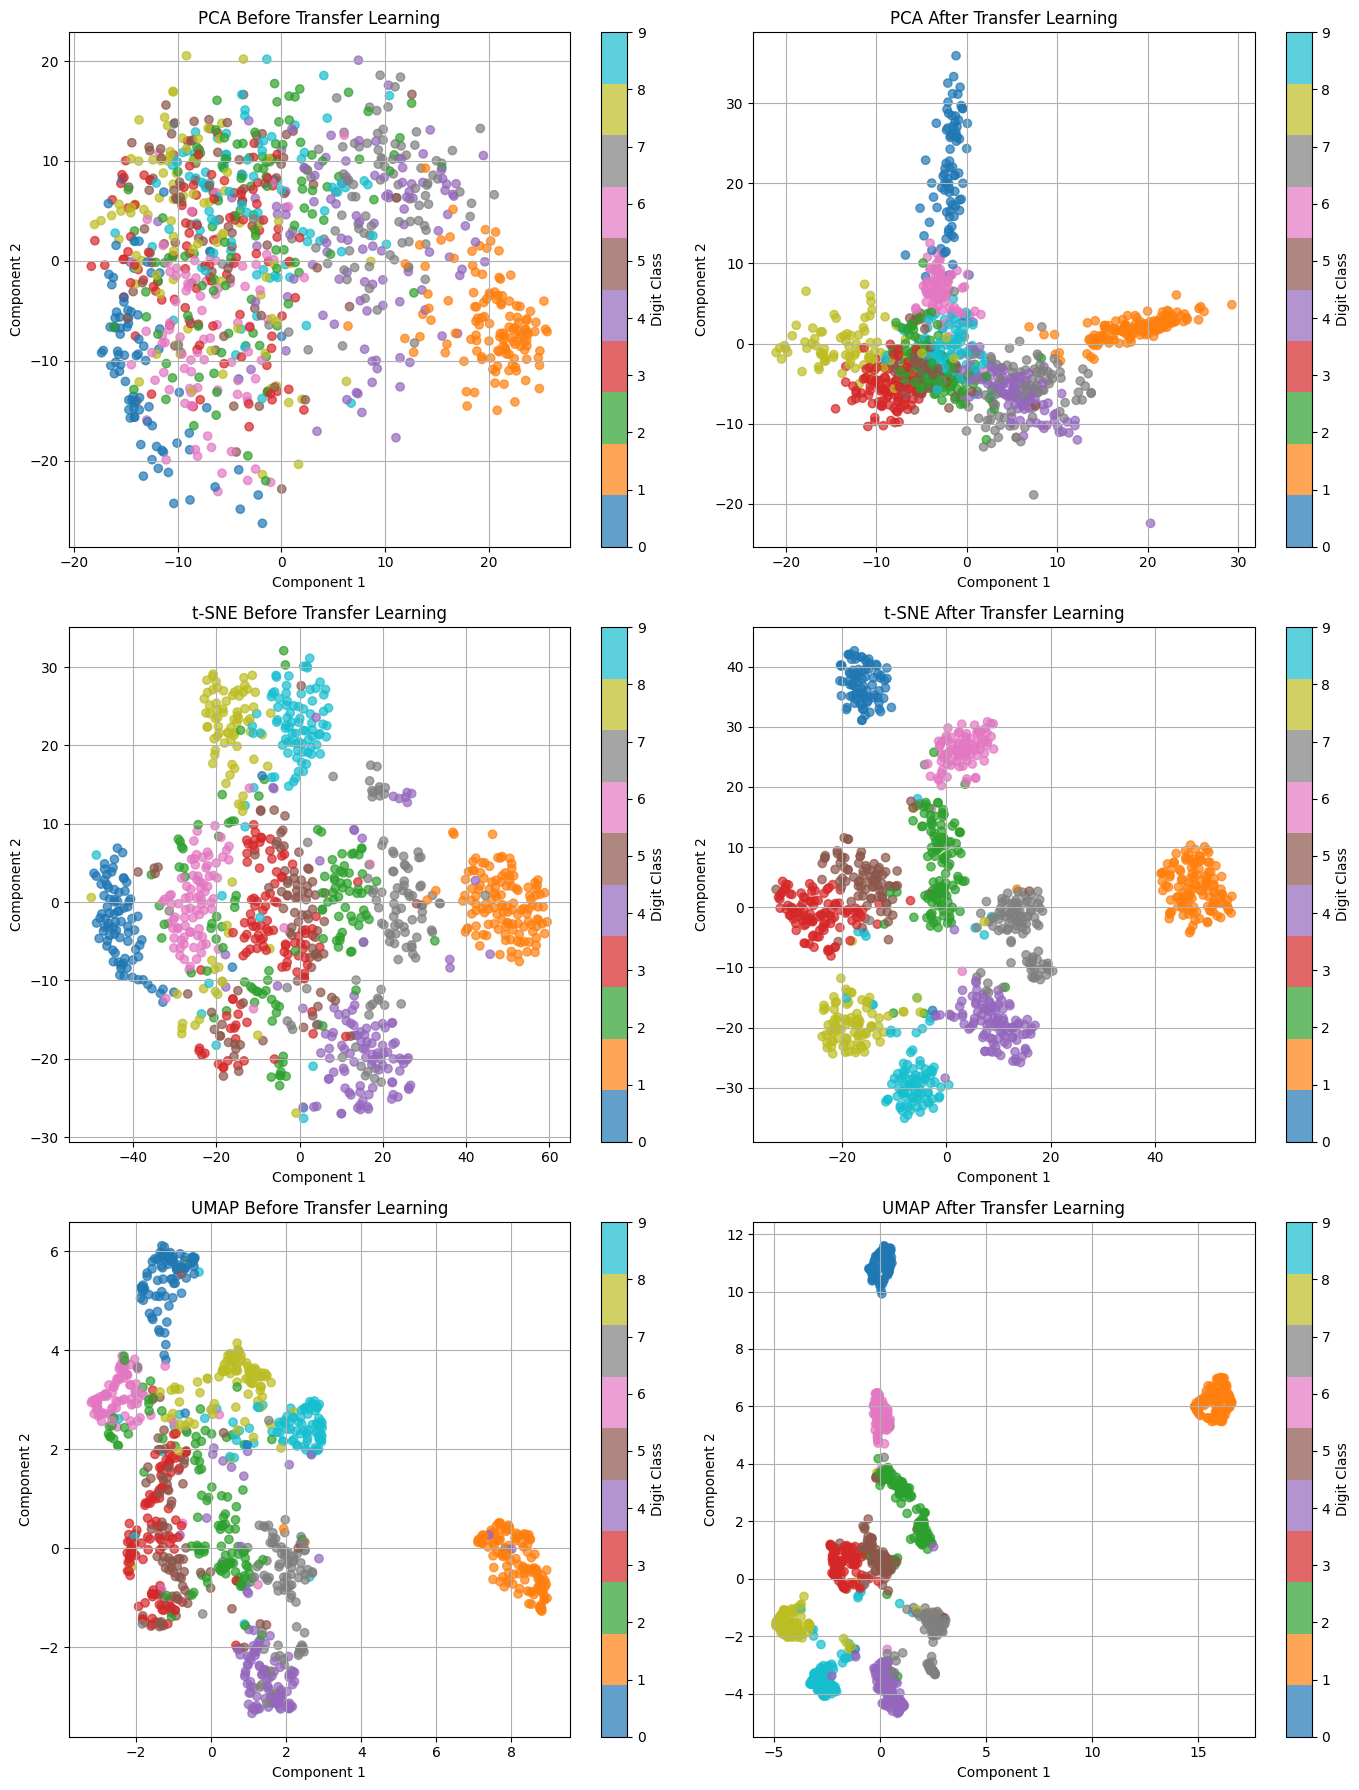

In [ ]:
def plot_3x2_subplots(features_before, features_after, labels):
    reducers = [
        ('PCA', PCA(n_components=2)),
        ('t-SNE', TSNE(n_components=2, perplexity=30)),
        ('UMAP', umap.UMAP(n_components=2))
    ]

    fig, axes = plt.subplots(3, 2, figsize=(14, 18))  # 3 rows, 2 columns

    for row_idx, (name, reducer) in enumerate(reducers):
        # Reduce before transfer learning features
        reduced_before = reducer.fit_transform(features_before)
        labels_trim_before = labels[:reduced_before.shape[0]]
        sc1 = axes[row_idx, 0].scatter(reduced_before[:, 0], reduced_before[:, 1],
                                      c=labels_trim_before, cmap='tab10', alpha=0.7)
        axes[row_idx, 0].set_title(f"{name} Before Transfer Learning")
        axes[row_idx, 0].set_xlabel("Component 1")
        axes[row_idx, 0].set_ylabel("Component 2")
        axes[row_idx, 0].grid(True)
        fig.colorbar(sc1, ax=axes[row_idx, 0], label="Digit Class")

        # Reduce after transfer learning features
        reduced_after = reducer.fit_transform(features_after)
        labels_trim_after = labels[:reduced_after.shape[0]]
        sc2 = axes[row_idx, 1].scatter(reduced_after[:, 0], reduced_after[:, 1],
                                      c=labels_trim_after, cmap='tab10', alpha=0.7)
        axes[row_idx, 1].set_title(f"{name} After Transfer Learning")
        axes[row_idx, 1].set_xlabel("Component 1")
        axes[row_idx, 1].set_ylabel("Component 2")
        axes[row_idx, 1].grid(True)
        fig.colorbar(sc2, ax=axes[row_idx, 1], label="Digit Class")

    plt.tight_layout()
    plt.show()



# If labels are one-hot encoded, convert to class indices
if len(labels.shape) > 1 and labels.shape[1] > 1:
    labels = np.argmax(labels, axis=1)

# Trim to smallest size to avoid mismatch
N = min(features_before.shape[0], features_after.shape[0], labels.shape[0])
features_before = features_before[:N]
features_after = features_after[:N]
labels = labels[:N]

# Scale features
features_before_scaled = StandardScaler().fit_transform(features_before)
features_after_scaled = StandardScaler().fit_transform(features_after)

# Call the plotting function
plot_3x2_subplots(features_before_scaled, features_after_scaled, labels)

In [ ]:
print(features_before.shape, labels.shape)


(1000, 1280) (1000,)
